In [14]:
# load the xslx file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing


# load the xlsx file
def load_xlsx(file):
    # read the xlsx file from the 5th line with header, only keep the first ns
    df = pd.read_excel(file, header=5, usecols=[0, 1])
    return df


data = load_xlsx("/users/vivianz/downloads/stocks.xlsx")
# only keep the 1st and 2nd column, name the first one as "Date" and the second one as "Price"
data.columns = ["Date", "Price"]
# handle missing values by filling the missing values with the next valid value
# data.ffill(inplace=True)
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)
# convert the "Date" column to datetime
data["Date"] = pd.to_datetime(data["Date"])
print(data.head())
print(data.tail())

        Date   Price
0 2006-02-07  125.48
1 2006-02-08  126.62
2 2006-02-09  126.41
3 2006-02-10  126.64
4 2006-02-13  126.41
           Date   Price
4561 2024-03-22  521.21
4562 2024-03-25  519.77
4563 2024-03-26  518.81
4564 2024-03-27  523.17
4565 2024-03-28  523.07


In [15]:
data.to_csv("./SPYclose.csv")

In [16]:
data = pd.read_csv("./SPYclose.csv")

data["Date"] = pd.to_datetime(data["Date"])

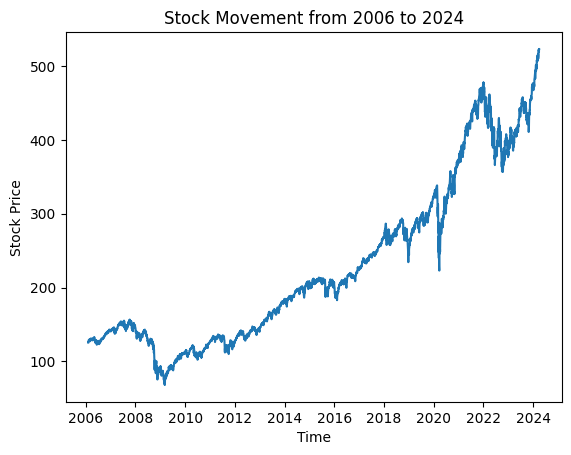

In [17]:
plt.plot(data["Date"], data["Price"])
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Stock Movement from 2006 to 2024")
plt.show()

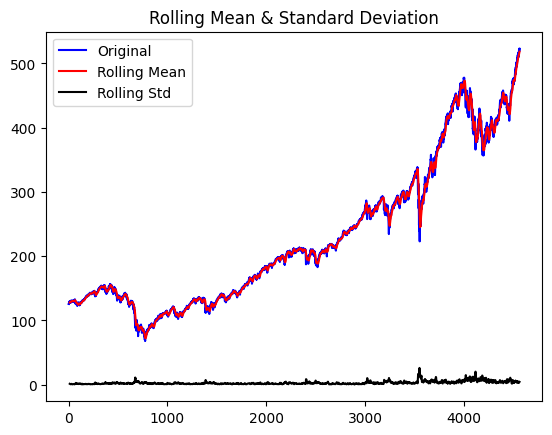

ADF Statistic: 1.482922
p-value: 0.997460
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [18]:
# create time series model and predict
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing


# check the stationarity of the time series
def check_stationarity(data):
    # rolling statistics
    rolling_mean = data.rolling(window=12).mean()
    rolling_std = data.rolling(window=12).std()
    # plot rolling statistics
    plt.plot(data, color="blue", label="Original")
    plt.plot(rolling_mean, color="red", label="Rolling Mean")
    plt.plot(rolling_std, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean & Standard Deviation")
    plt.show()
    # Dickey-Fuller test
    result = adfuller(data)
    print("ADF Statistic: %f" % result[0])
    print("p-value: %f" % result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print("\t%s: %.3f" % (key, value))


check_stationarity(data["Price"])

In [21]:
# split data into train,validation,test using index
train = data[: int(0.8 * len(data))]
validation = data[int(0.8 * len(data)) : int(0.9 * len(data))]
test = data[int(0.9 * len(data)) :]

print(train.head())
print(train.tail())
print(validation.head())

   Unnamed: 0       Date   Price
0           0 2006-02-07  125.48
1           1 2006-02-08  126.62
2           2 2006-02-09  126.41
3           3 2006-02-10  126.64
4           4 2006-02-13  126.41
      Unnamed: 0       Date   Price
3647        3647 2020-08-04  330.06
3648        3648 2020-08-05  332.11
3649        3649 2020-08-06  334.33
3650        3650 2020-08-07  334.57
3651        3651 2020-08-10  335.57
      Unnamed: 0       Date   Price
3652        3652 2020-08-11  332.80
3653        3653 2020-08-12  337.44
3654        3654 2020-08-13  336.83
3655        3655 2020-08-14  336.84
3656        3656 2020-08-17  337.91


In [22]:
# use auto_arima to find the best p,d,q
from pmdarima import auto_arima

stepwise_model = auto_arima(
    train["Price"],
    start_p=1,
    start_q=1,
    max_p=3,
    max_q=3,
    m=12,
    start_P=0,
    seasonal=True,
    d=1,
    D=1,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)
print(stepwise_model.aic())

# fit the model
stepwise_model.fit(train["Price"])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=6.23 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=18470.644, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=17543.064, Time=1.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.49 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=18416.070, Time=0.18 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=17050.776, Time=2.54 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=31.25 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=8.00 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=17137.089, Time=1.60 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=17033.874, Time=3.39 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=17518.130, Time=1.33 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=25.47 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=8.05 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=17034.196, Time=3.67 sec
 ARIMA(2,1,1)(2,1,0)[12]             : 

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

3652    333.792565
3653    335.170703
3654    335.736008
3655    333.624455
3656    335.483981
dtype: float64
4104    691.917655
4105    693.558971
4106    695.129621
4107    693.805607
4108    692.677350
dtype: float64
<class 'pandas.core.series.Series'>
      Unnamed: 0       Date   Price
3652        3652 2020-08-11  332.80
3653        3653 2020-08-12  337.44
3654        3654 2020-08-13  336.83
3655        3655 2020-08-14  336.84
3656        3656 2020-08-17  337.91
total: 457
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 3652
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -8511.937
Date:                            Thu, 04 Apr 2024   AIC                          17033.874
Time:                                    11:30:13   BIC                          17064.871
Sample:                                         0   HQIC      

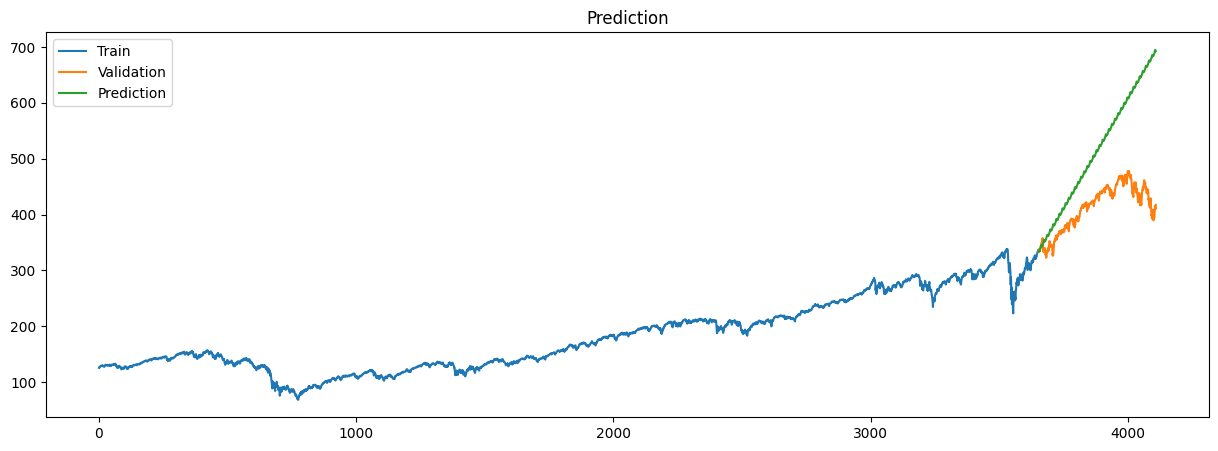

Mean Squared Error: 16010.93416950642
Root Mean Squared Error: 126.53432012504125
Mean Absolute Percentage Error: 0.24057231462840628


In [23]:
# predict the validation data
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    forecast = stepwise_model.predict(n_periods=len(validation))
    forecast_df = pd.DataFrame(forecast, index=validation.index, columns=["Prediction"])

print(forecast.head())
print(forecast.tail())
print(type(forecast))
# see if forecast has na values
# print("na values:", forecast.isna().sum())
print(validation.head())
print("total:", forecast.shape[0])
print(stepwise_model.summary())

print(validation["Price"])

# plot the prediction
plt.figure(figsize=(15, 5))
plt.plot(train["Price"], label="Train")
plt.plot(validation["Price"], label="Validation")
plt.plot(forecast_df["Prediction"], label="Prediction")
plt.legend(loc="best")
plt.title("Prediction")
plt.show()

# evaluate the forecast
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(validation["Price"], forecast_df["Prediction"])
print("Mean Squared Error:", mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)
mape = np.mean(
    np.abs(forecast_df["Prediction"] - validation["Price"])
    / np.abs(validation["Price"])
)
print("Mean Absolute Percentage Error:", mape)